In [396]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import chardet
import glob
import itertools
from IPython.display import display
import re

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

pd.set_option('display.max_rows', 25)

## Read the data

In [356]:
# Find the encoding of the csv files
with open("2024.csv", "rb") as f:
    result = chardet.detect(f.read(100000))  # Read a portion of the file
    encoding = result['encoding']
    print(f"Detected encoding: {encoding}")

# Read the file using the detected encoding
import pandas as pd
df = pd.read_csv("2024.csv", encoding=encoding, delimiter="\t")
# df.head()

Detected encoding: UTF-16


In [357]:
file_path = "*.csv"

# Get a list of all CSV file paths
csv_files = glob.glob(file_path)

# Read and combine all CSV files into one DataFrame
df_list = []
for file in csv_files:
    temp_df = pd.read_csv(file, encoding = "UTF-16", delimiter="\t")
    df_list.append(temp_df)

# Combine all data into a single DataFrame
df = pd.concat(df_list, ignore_index=True)
# df.head()

## Clean the Data

In [358]:
# Check and Clean the Data
# print("Info: \n",df.info(), '\n')   # Check for missing values and data types
# print('Description: \n',df.describe(), '\n')  # Summary statistics
# print('Count missing values: \n',df.isnull().sum(),'\n')  # Count missing values

In [359]:
# Drop unknown company names
df = df.dropna(subset=["Employer (Petitioner) Name"])

In [360]:
##### Fill missing Industry using Company
# Create a mapping of Company -> Industry (excluding NaN values)
company_to_industry = df.dropna(subset=["Industry (NAICS) Code"]).set_index("Employer (Petitioner) Name")["Industry (NAICS) Code"].to_dict()

# Fill missing Industry values by looking up the Company in the dictionary
df["Industry (NAICS) Code"] = df["Industry (NAICS) Code"].fillna(df["Employer (Petitioner) Name"].map(company_to_industry))

##### Fill missing Tax ID using Company
company_to_taxid = df.dropna(subset=["Tax ID"]).set_index("Employer (Petitioner) Name")["Tax ID"].to_dict()
df["Tax ID"] = df["Tax ID"].fillna(df["Employer (Petitioner) Name"].map(company_to_taxid))

##### Fill missing Industry using Tax ID
taxid_to_industry = df.dropna(subset=["Industry (NAICS) Code", "Tax ID"]).set_index("Tax ID")["Industry (NAICS) Code"].to_dict()
df["Industry (NAICS) Code"] = df["Industry (NAICS) Code"].fillna(df["Tax ID"].map(taxid_to_industry))

##### Fill missing State using Company
company_to_state = df.dropna(subset=["Petitioner State"]).set_index("Employer (Petitioner) Name")["Petitioner State"].to_dict()
df["Petitioner State"] = df["Petitioner State"].fillna(df["Employer (Petitioner) Name"].map(company_to_state))

In [361]:
print("Info: \n",df.info(), '\n')
print('Count missing values: \n',df.isnull().sum(),'\n')

<class 'pandas.core.frame.DataFrame'>
Index: 574781 entries, 3 to 574810
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Line by line                574781 non-null  object 
 1   Fiscal Year                 574781 non-null  int64  
 2   Employer (Petitioner) Name  574781 non-null  object 
 3   Tax ID                      573583 non-null  float64
 4   Industry (NAICS) Code       574703 non-null  object 
 5   Petitioner City             574779 non-null  object 
 6   Petitioner State            574765 non-null  object 
 7   Petitioner Zip Code         574708 non-null  float64
 8   Initial Approval            574781 non-null  object 
 9   Initial Denial              574781 non-null  object 
 10  Continuing Approval         574781 non-null  object 
 11  Continuing Denial           574781 non-null  object 
dtypes: float64(2), int64(1), object(9)
memory usage: 57.0+ MB
Info: 
 None 

Coun

In [362]:
def string_to_number(s):
    """Converts a string with commas to a number (float).
       If no comma, attempts to convert directly.
    """
    try:
        if isinstance(s, str) and "," in s:
            return int(s.replace(",", ""))
        else:
            return int(s)
    except (ValueError, TypeError):
        return None 
        
df['Tax ID'] = df['Tax ID'].apply(string_to_number)
df['Initial Approval'] = df['Initial Approval'].apply(string_to_number)
df['Initial Denial'] = df['Initial Denial'].apply(string_to_number)
df['Continuing Approval'] = df['Continuing Approval'].apply(string_to_number)
df['Continuing Denial'] = df['Continuing Denial'].apply(string_to_number)

In [363]:
df.drop('Line by line', axis=1)
# Change som column names
df.rename(columns={'Fiscal Year   ':'Year', 'Industry (NAICS) Code':'Industry', 'Employer (Petitioner) Name':'Company', 'Petitioner State':'State'}, inplace=True)

## Group Data (if needed)

In [364]:
df_1 = df.groupby(['Company', 'Year'], as_index=False).agg({
    'Company': 'first',
    'Tax ID': 'first',
    'Industry': 'first',
    'State': 'first',
    'Initial Approval': 'sum',
    'Initial Denial': 'sum',
    'Continuing Approval': 'sum',
    'Continuing Denial': 'sum'
})

# df_1.head(10)

In [365]:
df_1['Total Approval'] = df_1['Initial Approval']+df_1['Continuing Approval']
df_1['Total Denial'] = df_1['Initial Denial']+df_1['Continuing Denial']

In [366]:
print("Info: \n",df_1.info(), '\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487719 entries, 0 to 487718
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Year                 487719 non-null  int64  
 1   Company              487719 non-null  object 
 2   Tax ID               486529 non-null  float64
 3   Industry             487641 non-null  object 
 4   State                487703 non-null  object 
 5   Initial Approval     487719 non-null  int64  
 6   Initial Denial       487719 non-null  int64  
 7   Continuing Approval  487719 non-null  int64  
 8   Continuing Denial    487719 non-null  int64  
 9   Total Approval       487719 non-null  int64  
 10  Total Denial         487719 non-null  int64  
dtypes: float64(1), int64(7), object(3)
memory usage: 40.9+ MB
Info: 
 None 



## Data Analytics

In [367]:
industry = {'Agriculture':'11 - Agriculture, Forestry, Fishing and Hunting',
            'Oil and Gas':'21 - Mining, Quarrying, and Oil and Gas Extraction', 
            'Utilities':'22 - Utilities', 
            'Construction':'23 - Construction', 
            'Manufacturing':'31-33 - Manufacturing',
            'Wholesale':'42 - Wholesale Trade', 
            'Retail':'44-45 - Retail Trade', 
            'Transportation':'48-49 - Transportation and Warehousing', 
            'Information':'51 - Information', 
            'Finance':'52 - Finance and Insurance', 
            'Real Estate':'53 - Real Estate and Rental and Leasing', 
            'PSTS':'54 - Professional, Scientific, and Technical Services',
            'Management':'55 - Management of Companies and Enterprises', 
            'Admin':'56 - Administrative and Support and Waste Management and Remediation Services', 
            'Education':'61 - Educational Services', 
            'Health':'62 - Health Care and Social Assistance', 
            'Arts':'71 - Arts, Entertainment, and Recreation', 
            'Accommodation':'72 - Accommodation and Food Services', 
            'Other':'81 - Other Services (except Public Administration)', 
            'Public Administration':'92 - Public Administration'}


year_list = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]

In [368]:
df_temp = df_1.dropna(subset=['Industry'])
df_manufacturing = df_1[(df_1['Industry'] == industry['Manufacturing']) & (df_1['Year'] == 2020)]
topcompany = df_manufacturing.sort_values(by='Total Approval', ascending=False).head(5)
# print(topcompany.to_string(index=False))
topcompany

,Year,Company,Tax ID,Industry,State,Initial Approval,Initial Denial,Continuing Approval,Continuing Denial,Total Approval,Total Denial
32586,2020,APPLE INC,4410.0,31-33 - Manufacturing,CA,749,8,3133,14,3882,22
216408,2020,INTEL CORPORATION,2723.0,31-33 - Manufacturing,AZ,743,19,1976,35,2719,54
89716,2020,CISCO SYSTEMS INC,9951.0,31-33 - Manufacturing,CA,488,28,1497,32,1985,60
346102,2020,QUALCOMM TECHNOLOGIES INC,1577.0,31-33 - Manufacturing,CA,464,2,974,22,1438,24
307294,2020,NVIDIA CORPORATION,7549.0,31-33 - Manufacturing,CA,188,5,585,2,773,7


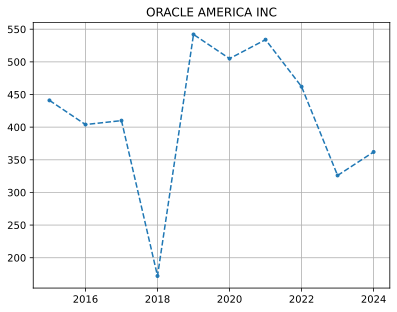

In [371]:
def companyspecific(df,company_name, graph=False):
    '''
    This function finds the companies
    '''
    df_company = df[df['Company'].str.contains(company_name, na=False)]
    df_company = df_company.groupby(['Year', 'Tax ID'], as_index=False).agg({
        'Company': 'first',
        # 'Tax ID': 'first',
        'Industry': 'first',
        'State': 'first',
        'Initial Approval': 'sum',
        'Initial Denial': 'sum',
        'Continuing Approval': 'sum',
        'Continuing Denial': 'sum'
    })
    if graph == True:
        plt.plot(df_company['Year'], df_company['Initial Approval'],'.--')
        # plt.plot(oracle['Year'], oracle['Initial Approval'], '.--', label='oracle')
        plt.title(df_company['Company'].iloc[0])
        plt.grid()
        # plt.legend()
        plt.show()
        
    return df_company

oracle = companyspecific(df_1,'ORACLE AMERICA', graph=True)
oracle_filter = oracle[(oracle['State'] == 'TX') | (oracle['State'] == 'CA') | (oracle['State'] == 'WA')]

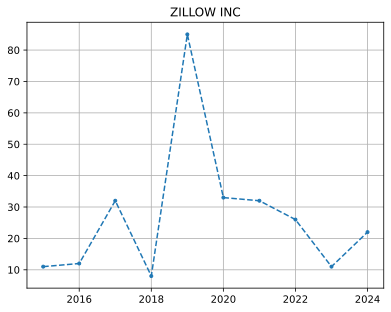

,Year,Tax ID,Company,Industry,State,Initial Approval,Initial Denial,Continuing Approval,Continuing Denial
0,2015,33.0,ZILLOW INC,53 - Real Estate and Rental and Leasing,WA,11,0,13,0
1,2016,33.0,ZILLOW INC,53 - Real Estate and Rental and Leasing,WA,12,0,70,1
2,2017,33.0,ZILLOW INC,51 - Information,WA,32,2,49,0
3,2018,33.0,ZILLOW INC,53 - Real Estate and Rental and Leasing,WA,8,5,97,3
4,2019,33.0,ZILLOW INC,53 - Real Estate and Rental and Leasing,WA,85,3,94,7
5,2020,33.0,ZILLOW INC,53 - Real Estate and Rental and Leasing,CA,33,0,126,2
6,2021,33.0,ZILLOW INC,53 - Real Estate and Rental and Leasing,CA,32,1,178,0
7,2022,33.0,ZILLOW INC,53 - Real Estate and Rental and Leasing,WA,26,0,136,1
8,2023,33.0,ZILLOW INC,53 - Real Estate and Rental and Leasing,WA,11,0,146,8
9,2024,33.0,ZILLOW INC,53 - Real Estate and Rental and Leasing,WA,22,0,94,2


In [403]:
company = companyspecific(df_1,"ZILLOW INC", graph=True)

company

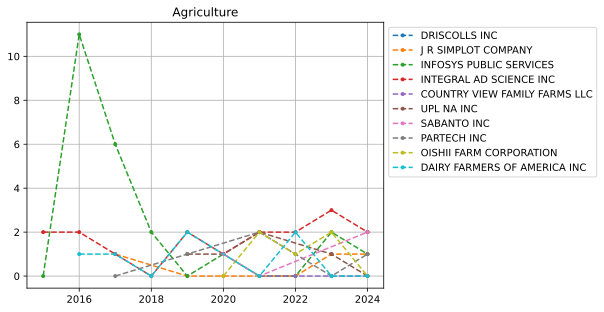

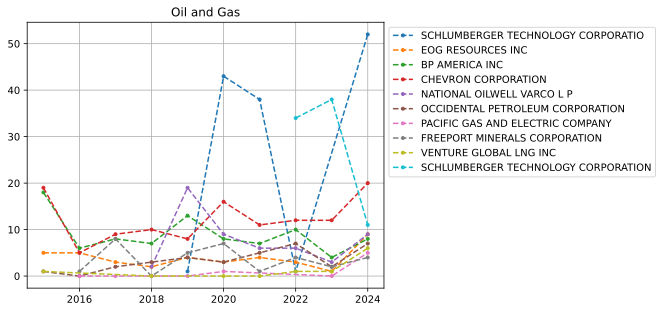

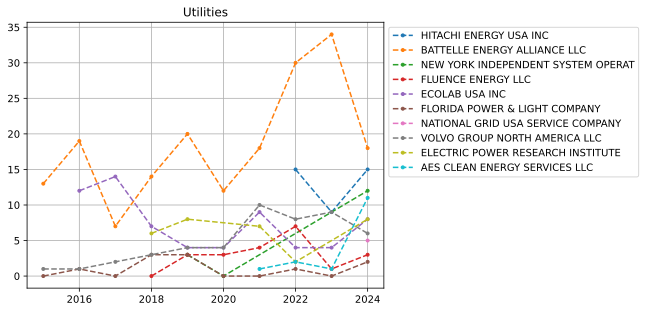

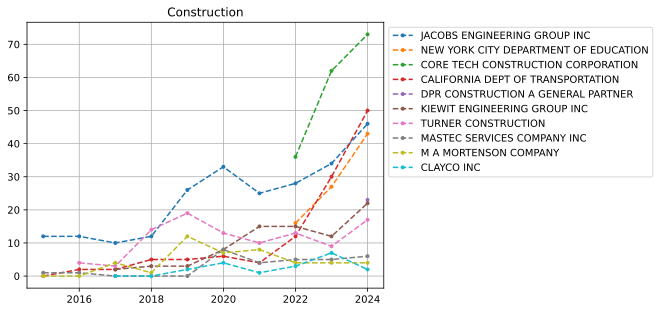

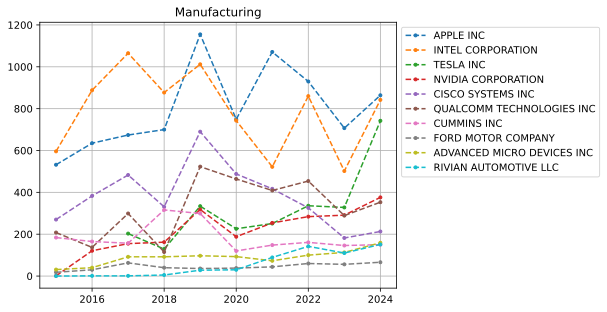

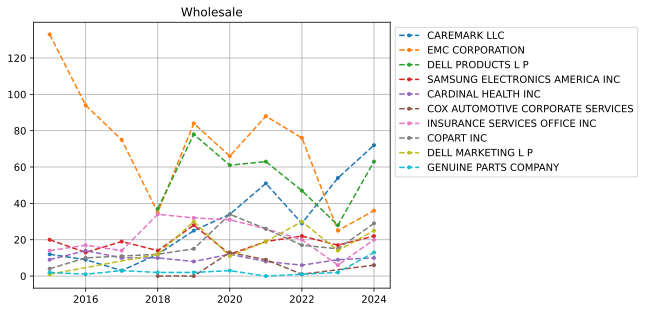

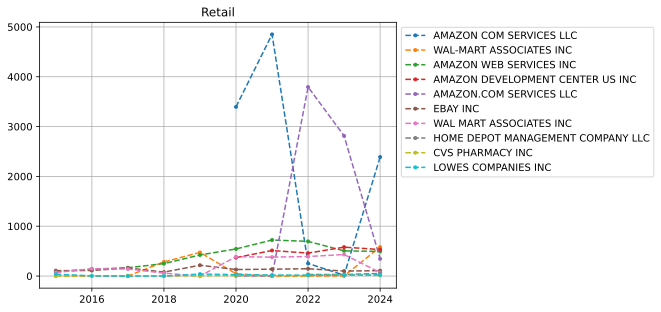

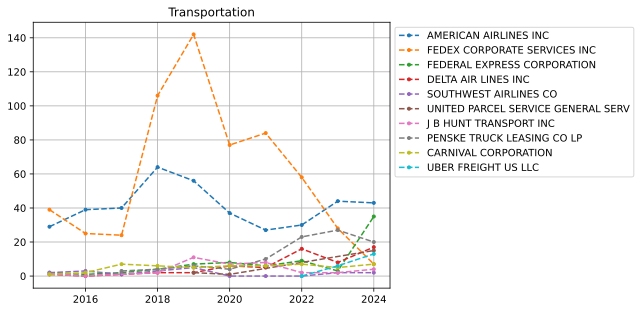

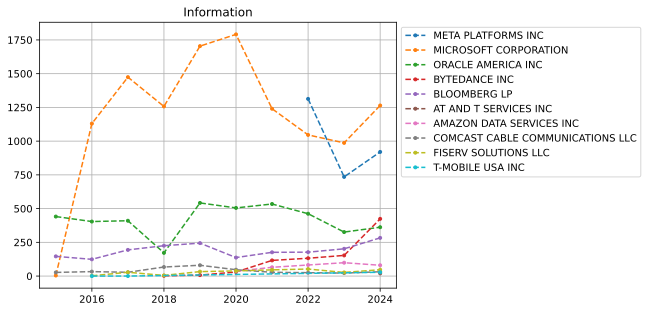

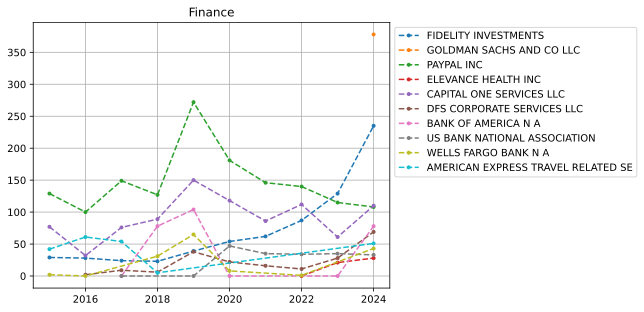

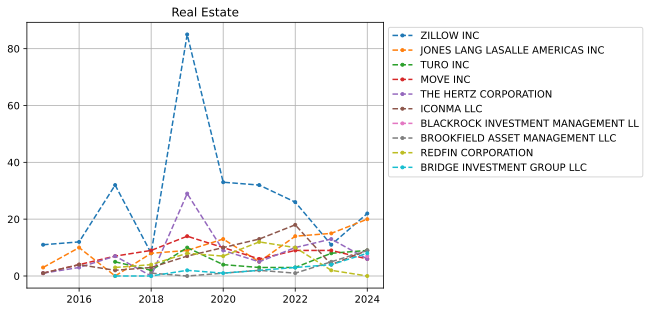

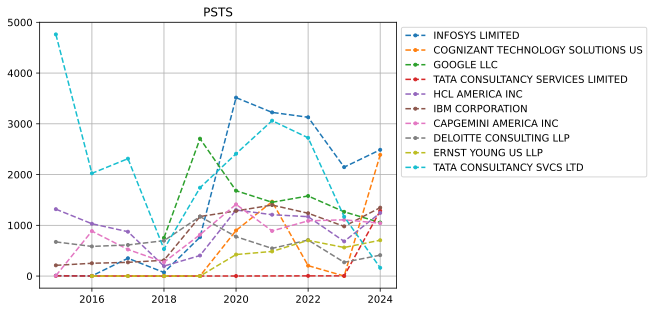

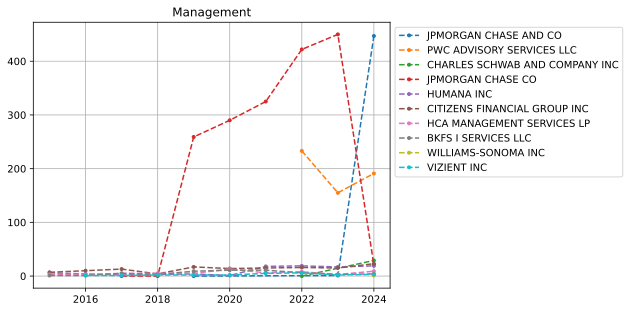

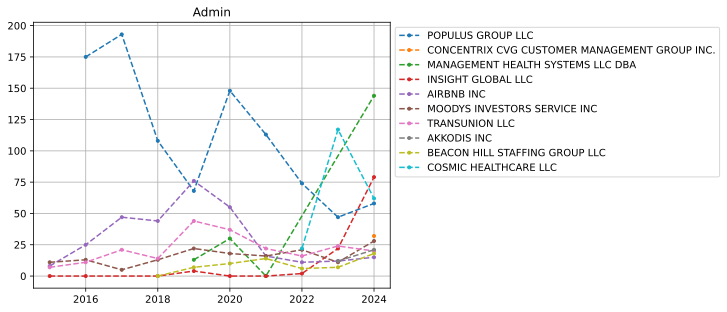

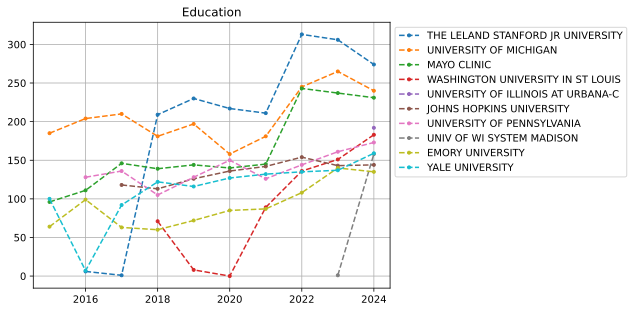

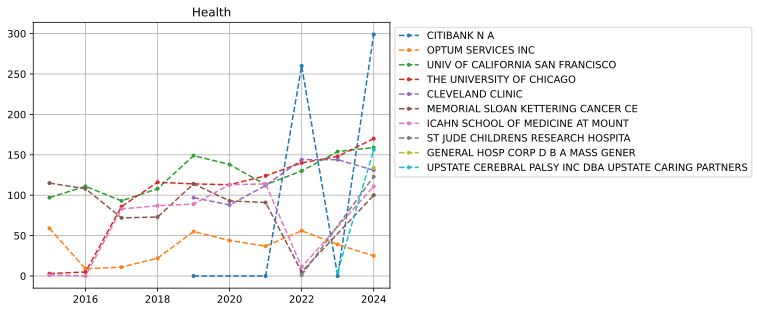

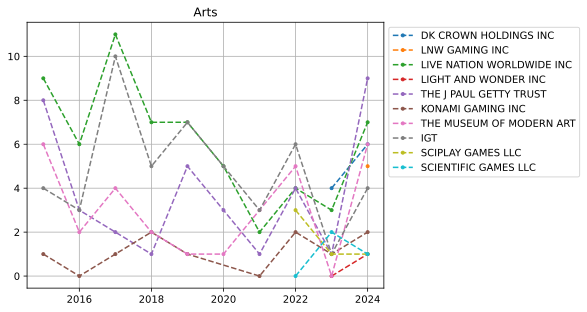

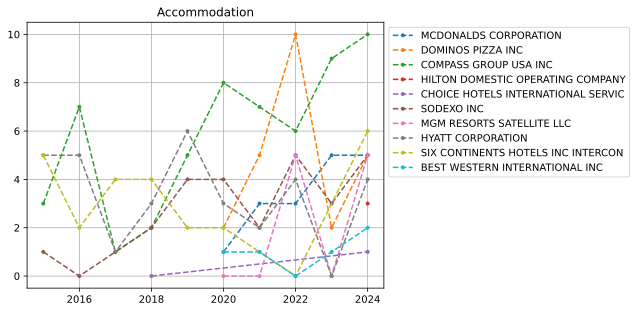

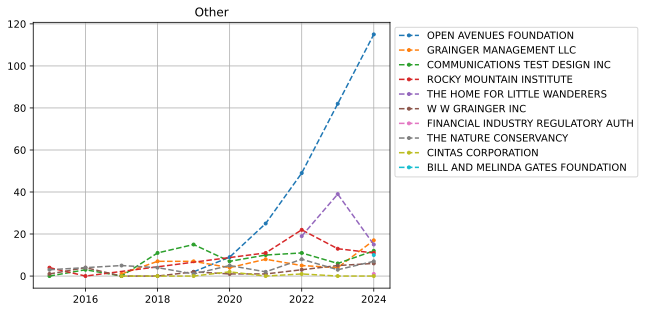

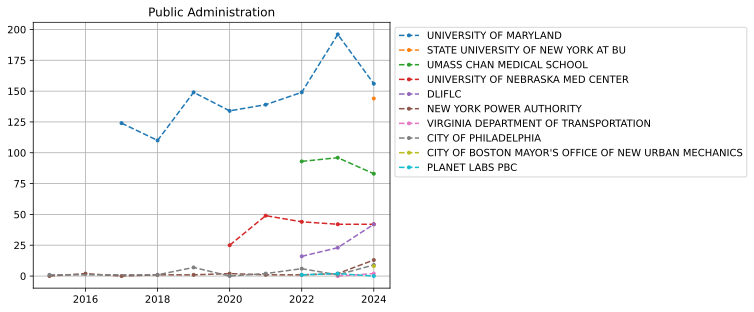

In [350]:
def rankcompany(df, industry_name, year, no_of_companies=5):
    '''
    This function finds the 
    '''
    df_industry = df[(df['Industry'] == industry[industry_name]) & (df['Year'] == year)]
    topcompany = df_industry.sort_values(by='Total Approval', ascending=False).head(no_of_companies)
    topcompany
    for i in range(0,no_of_companies):
        df_company = df[df['Company'] == topcompany['Company'].iloc[i]] # finds the company in df that has the name associated with location i in topcompany. This is the dataframe for that specific company
        plt.plot(df_company['Year'],df_company['Initial Approval'], '.--', label=topcompany['Company'].iloc[i]) # plot all the year and value for that specific company

    plt.title(industry_name)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid()
    plt.show()

industry_name = 'Manufacturing'
year = 2024

for industry_name in industry:
    rankcompany(df_1, industry_name, year, no_of_companies=10)